# Bespoke retrieval based on CLIP embedding vectors

In [1]:
from superduperdb.client import the_client

docs = the_client.coco.documents

In the notebook from the previous chapter we implemented retrieval based on a pretrained CLIP model from open-source. In this notebook we will train our own model based on a simpler architecture, but which has the upside of increased efficiency compared to the original model.

To this end we will first implement a simpler sentence embedding, using a simple word-embedding approach based around Glove. 

Get the embeddings first if you haven't already:

In [ ]:
!curl https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip glove.6B.zip

In [4]:
!pygmentize examples/coco/glove.py

import re
import torch


class AverageOfGloves:
    def __init__(self, embeddings, index):
        self.embeddings = embeddings
        self.index = index
        self.lookup = dict(zip(self.index, range(len(self.index))))

    def preprocess(self, sentence):
        if isinstance(sentence, list):
            sentence = ' '.join(sentence)
        cleaned = re.sub('[^a-z0-9 ]', ' ',  sentence.lower())
        cleaned = re.sub('[ ]+', ' ',  cleaned)
        words = cleaned.split()
        words = [x for x in words if x in self.index]
        if not words:
            return torch.ones(50).type(torch.float)
        ix = list(map(self.lookup.__getitem__, words))
        vectors = self.embeddings[ix, :]
        return vectors.mean(0)


In [3]:
import numpy
import torch
from examples.coco.glove import AverageOfGloves

with open('glove.6B.50d.txt') as f:
    lines = f.read().split('\n')
    
lines = [x.split(' ') for x in lines[:-1]]
index = [x[0] for x in lines]
vectors = [[float(y) for y in x[1:]] for x in lines]
vectors = numpy.array(vectors)

glove = AverageOfGloves(torch.from_numpy(vectors).type(torch.float), index)

docs.create_model(
    'average_glove',
    glove,
    type='float_tensor',
)

Since the glove vectors are smaller than the output of the CLIP model, we will create a linear projection of the CLIP embeddings so that the outputs over image inputs have the same size as the glove embeddings.

In [4]:
docs.create_model(
    'clip_projection',
    object=torch.nn.Linear(1024, 50),
    type='float_tensor',
)

Let's also create a loss function `ranking_loss`, in order to be able to perform the learning task.

In [6]:
!pygmentize examples/coco/ranking_loss.py

import torch


def ranking_loss(x, y):
    x = x.div(x.norm(dim=1)[:, None])
    y = y.div(y.norm(dim=1)[:, None])
    similarities = x.matmul(y.T)
    return -torch.nn.functional.log_softmax(similarities, dim=1).diag().mean()


In [5]:
from examples.coco.ranking_loss import ranking_loss

docs.create_objective('ranking_loss', ranking_loss)

A semantic index training requires:

- 1 or more models
- A measure function to measure similarity between model outputs
- An objective (loss) function
- One or more validation sets
- One or more metrics to measure performance

In [6]:
docs.list_models()

['average_glove', 'clip', 'clip_projection']

In [7]:
docs.list_measures()

['css']

In [8]:
docs.list_objectives()

['ranking_loss']

In [9]:
docs.list_validation_sets()

['text2image_retrieval']

In [10]:
docs.list_metrics()

['p_at_10']

We now have all of these things ready and registered with the database, so we can start the training:

In [11]:
docs.create_semantic_index(
    'simple_image_search',
    models=['clip_projection', 'average_glove'],
    keys=['img', 'captions'],
    objective='ranking_loss',
    filter={},
    features={'img': 'clip'},
    metrics=['p_at_10'],
    measure='css',
    validation_sets=['text2image_retrieval'],
    batch_size=250,
    num_workers=0,
    n_epochs=20,
    lr=0.001,
    log_weights=True,
    download=True,
    validation_interval=50,
    no_improve_then_stop=5,
    n_iterations=5000,
    use_grads={'clip_projection': True, 'average_glove': False},
)

downloading ids for {'_fold': 'train'}


  0%|          | 0/77743 [00:00<?, ?it/s]

downloading records for {'_fold': 'valid'}


  0%|          | 0/4040 [00:00<?, ?it/s]

computing chunk (1/1)
finding documents under filter
done.
processing with clip_projection


  0%|          | 0/1000 [00:00<?, ?it/s]

bulk writing...
done.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

loading hashes: "simple_image_search"
fold: VALID; iteration: 0; epoch: 0; text2image_retrieval/p_at_10: 0.006; objective: 5.417091565973618; 
fold: TRAIN; iteration: 0; epoch: 0; objective: 5.524089813232422; 
fold: TRAIN; iteration: 1; epoch: 0; objective: 5.505591869354248; 
fold: TRAIN; iteration: 2; epoch: 0; objective: 5.489068508148193; 
fold: TRAIN; iteration: 3; epoch: 0; objective: 5.472532272338867; 
fold: TRAIN; iteration: 4; epoch: 0; objective: 5.454397678375244; 
fold: TRAIN; iteration: 5; epoch: 0; objective: 5.427471160888672; 
fold: TRAIN; iteration: 6; epoch: 0; objective: 5.419985294342041; 
fold: TRAIN; iteration: 7; epoch: 0; objective: 5.410735607147217; 
fold: TRAIN; iteration: 8; epoch: 0; objective: 5.394529342651367; 
fold: TRAIN; iteration: 9; epoch: 0; objective: 5.39639949798584; 
fold: TRAIN; iteration: 10; epoch: 0; objective: 5.379389762878418; 
fold: TRAIN; iteration: 11; epoch: 0; objective: 5.387411117553711; 
fold: TRAIN; iteration: 12; epoch: 0; ob

  0%|          | 0/1000 [00:00<?, ?it/s]

bulk writing...
done.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

loading hashes: "simple_image_search"
saving
fold: VALID; iteration: 50; epoch: 0; text2image_retrieval/p_at_10: 0.233; objective: 5.224311730440925; 
fold: TRAIN; iteration: 50; epoch: 0; objective: 5.338551044464111; 
fold: TRAIN; iteration: 51; epoch: 0; objective: 5.3397111892700195; 
fold: TRAIN; iteration: 52; epoch: 0; objective: 5.326765060424805; 
fold: TRAIN; iteration: 53; epoch: 0; objective: 5.322484493255615; 
fold: TRAIN; iteration: 54; epoch: 0; objective: 5.333186149597168; 
fold: TRAIN; iteration: 55; epoch: 0; objective: 5.3290605545043945; 
fold: TRAIN; iteration: 56; epoch: 0; objective: 5.332774639129639; 
fold: TRAIN; iteration: 57; epoch: 0; objective: 5.333982467651367; 
fold: TRAIN; iteration: 58; epoch: 0; objective: 5.334574222564697; 
fold: TRAIN; iteration: 59; epoch: 0; objective: 5.328280448913574; 
fold: TRAIN; iteration: 60; epoch: 0; objective: 5.324556827545166; 
fold: TRAIN; iteration: 61; epoch: 0; objective: 5.327946186065674; 
fold: TRAIN; iterat

  0%|          | 0/1000 [00:00<?, ?it/s]

bulk writing...
done.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

loading hashes: "simple_image_search"
saving
fold: VALID; iteration: 100; epoch: 0; text2image_retrieval/p_at_10: 0.317; objective: 5.217227178461411; 
fold: TRAIN; iteration: 100; epoch: 0; objective: 5.325514793395996; 
fold: TRAIN; iteration: 101; epoch: 0; objective: 5.3208770751953125; 
fold: TRAIN; iteration: 102; epoch: 0; objective: 5.328906059265137; 
fold: TRAIN; iteration: 103; epoch: 0; objective: 5.325454235076904; 
fold: TRAIN; iteration: 104; epoch: 0; objective: 5.32430362701416; 
fold: TRAIN; iteration: 105; epoch: 0; objective: 5.329595565795898; 
fold: TRAIN; iteration: 106; epoch: 0; objective: 5.323193073272705; 
fold: TRAIN; iteration: 107; epoch: 0; objective: 5.3223443031311035; 
fold: TRAIN; iteration: 108; epoch: 0; objective: 5.3271379470825195; 
fold: TRAIN; iteration: 109; epoch: 0; objective: 5.319332599639893; 
fold: TRAIN; iteration: 110; epoch: 0; objective: 5.32206916809082; 
fold: TRAIN; iteration: 111; epoch: 0; objective: 5.322122097015381; 
fold: T

  0%|          | 0/1000 [00:00<?, ?it/s]

bulk writing...
done.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

loading hashes: "simple_image_search"
saving
fold: VALID; iteration: 150; epoch: 0; text2image_retrieval/p_at_10: 0.341; objective: 5.215378424700568; 
fold: TRAIN; iteration: 150; epoch: 0; objective: 5.312405586242676; 
fold: TRAIN; iteration: 151; epoch: 0; objective: 5.324182987213135; 
fold: TRAIN; iteration: 152; epoch: 0; objective: 5.323192119598389; 
fold: TRAIN; iteration: 153; epoch: 0; objective: 5.327282428741455; 
fold: TRAIN; iteration: 154; epoch: 0; objective: 5.319421291351318; 
fold: TRAIN; iteration: 155; epoch: 0; objective: 5.3235697746276855; 
fold: TRAIN; iteration: 156; epoch: 0; objective: 5.321167945861816; 
fold: TRAIN; iteration: 157; epoch: 0; objective: 5.315560340881348; 
fold: TRAIN; iteration: 158; epoch: 0; objective: 5.32195520401001; 
fold: TRAIN; iteration: 159; epoch: 0; objective: 5.325678825378418; 
fold: TRAIN; iteration: 160; epoch: 0; objective: 5.3207478523254395; 
fold: TRAIN; iteration: 161; epoch: 0; objective: 5.326735496520996; 
fold: T

  0%|          | 0/1000 [00:00<?, ?it/s]

bulk writing...
done.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

loading hashes: "simple_image_search"
saving
fold: VALID; iteration: 200; epoch: 0; text2image_retrieval/p_at_10: 0.34; objective: 5.214197271010455; 
fold: TRAIN; iteration: 200; epoch: 0; objective: 5.321757793426514; 
fold: TRAIN; iteration: 201; epoch: 0; objective: 5.319576740264893; 
fold: TRAIN; iteration: 202; epoch: 0; objective: 5.314815044403076; 
fold: TRAIN; iteration: 203; epoch: 0; objective: 5.319633960723877; 
fold: TRAIN; iteration: 204; epoch: 0; objective: 5.319507598876953; 
fold: TRAIN; iteration: 205; epoch: 0; objective: 5.316718101501465; 
fold: TRAIN; iteration: 206; epoch: 0; objective: 5.323395252227783; 
fold: TRAIN; iteration: 207; epoch: 0; objective: 5.327869415283203; 
fold: TRAIN; iteration: 208; epoch: 0; objective: 5.324555397033691; 
fold: TRAIN; iteration: 209; epoch: 0; objective: 5.32435941696167; 
fold: TRAIN; iteration: 210; epoch: 0; objective: 5.31551456451416; 
fold: TRAIN; iteration: 211; epoch: 0; objective: 5.319411754608154; 
fold: TRAIN

  0%|          | 0/1000 [00:00<?, ?it/s]

bulk writing...
done.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

loading hashes: "simple_image_search"
saving
fold: VALID; iteration: 250; epoch: 0; text2image_retrieval/p_at_10: 0.355; objective: 5.2134396889630485; 
fold: TRAIN; iteration: 250; epoch: 0; objective: 5.325177192687988; 
fold: TRAIN; iteration: 251; epoch: 0; objective: 5.316627502441406; 
fold: TRAIN; iteration: 252; epoch: 0; objective: 5.320126056671143; 
fold: TRAIN; iteration: 253; epoch: 0; objective: 5.317678928375244; 
fold: TRAIN; iteration: 254; epoch: 0; objective: 5.3187971115112305; 
fold: TRAIN; iteration: 255; epoch: 0; objective: 5.3133392333984375; 
fold: TRAIN; iteration: 256; epoch: 0; objective: 5.317606449127197; 
fold: TRAIN; iteration: 257; epoch: 0; objective: 5.319932460784912; 
fold: TRAIN; iteration: 258; epoch: 0; objective: 5.320897579193115; 
fold: TRAIN; iteration: 259; epoch: 0; objective: 5.319098472595215; 
fold: TRAIN; iteration: 260; epoch: 0; objective: 5.320389747619629; 
fold: TRAIN; iteration: 261; epoch: 0; objective: 5.324409484863281; 
fold:

  0%|          | 0/1000 [00:00<?, ?it/s]

bulk writing...
done.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

loading hashes: "simple_image_search"
saving
fold: VALID; iteration: 300; epoch: 0; text2image_retrieval/p_at_10: 0.355; objective: 5.213074249379775; 
fold: TRAIN; iteration: 300; epoch: 0; objective: 5.3207478523254395; 
fold: TRAIN; iteration: 301; epoch: 0; objective: 5.324264049530029; 
fold: TRAIN; iteration: 302; epoch: 0; objective: 5.3232421875; 
fold: TRAIN; iteration: 303; epoch: 0; objective: 5.3155927658081055; 
fold: TRAIN; iteration: 304; epoch: 0; objective: 5.325338363647461; 
fold: TRAIN; iteration: 305; epoch: 0; objective: 5.318785667419434; 
fold: TRAIN; iteration: 306; epoch: 0; objective: 5.322279453277588; 
fold: TRAIN; iteration: 307; epoch: 0; objective: 5.317646503448486; 
fold: TRAIN; iteration: 308; epoch: 0; objective: 5.322110176086426; 
fold: TRAIN; iteration: 309; epoch: 0; objective: 5.32066011428833; 
fold: TRAIN; iteration: 310; epoch: 0; objective: 5.29600715637207; 
fold: TRAIN; iteration: 311; epoch: 1; objective: 5.3218278884887695; 
fold: TRAIN;

  0%|          | 0/1000 [00:00<?, ?it/s]

bulk writing...
done.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

loading hashes: "simple_image_search"
saving
fold: VALID; iteration: 350; epoch: 1; text2image_retrieval/p_at_10: 0.335; objective: 5.212984996683457; 
fold: TRAIN; iteration: 350; epoch: 1; objective: 5.320950031280518; 
fold: TRAIN; iteration: 351; epoch: 1; objective: 5.318922519683838; 
fold: TRAIN; iteration: 352; epoch: 1; objective: 5.322129249572754; 
fold: TRAIN; iteration: 353; epoch: 1; objective: 5.3205952644348145; 
fold: TRAIN; iteration: 354; epoch: 1; objective: 5.3186492919921875; 
fold: TRAIN; iteration: 355; epoch: 1; objective: 5.323493957519531; 
fold: TRAIN; iteration: 356; epoch: 1; objective: 5.310271263122559; 
fold: TRAIN; iteration: 357; epoch: 1; objective: 5.3198561668396; 
fold: TRAIN; iteration: 358; epoch: 1; objective: 5.317119121551514; 
fold: TRAIN; iteration: 359; epoch: 1; objective: 5.315925598144531; 
fold: TRAIN; iteration: 360; epoch: 1; objective: 5.326632976531982; 
fold: TRAIN; iteration: 361; epoch: 1; objective: 5.325036525726318; 
fold: TR

  0%|          | 0/1000 [00:00<?, ?it/s]

bulk writing...
done.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

loading hashes: "simple_image_search"
saving
fold: VALID; iteration: 400; epoch: 1; text2image_retrieval/p_at_10: 0.358; objective: 5.2126273968640495; 
fold: TRAIN; iteration: 400; epoch: 1; objective: 5.308872222900391; 
fold: TRAIN; iteration: 401; epoch: 1; objective: 5.32319450378418; 
fold: TRAIN; iteration: 402; epoch: 1; objective: 5.324280738830566; 
fold: TRAIN; iteration: 403; epoch: 1; objective: 5.315586090087891; 
fold: TRAIN; iteration: 404; epoch: 1; objective: 5.318851470947266; 
fold: TRAIN; iteration: 405; epoch: 1; objective: 5.3226141929626465; 
fold: TRAIN; iteration: 406; epoch: 1; objective: 5.317885875701904; 
fold: TRAIN; iteration: 407; epoch: 1; objective: 5.313289165496826; 
fold: TRAIN; iteration: 408; epoch: 1; objective: 5.320749282836914; 
fold: TRAIN; iteration: 409; epoch: 1; objective: 5.314390182495117; 
fold: TRAIN; iteration: 410; epoch: 1; objective: 5.312128067016602; 
fold: TRAIN; iteration: 411; epoch: 1; objective: 5.312901496887207; 
fold: T

  0%|          | 0/1000 [00:00<?, ?it/s]

bulk writing...
done.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

loading hashes: "simple_image_search"
no best model found...
fold: VALID; iteration: 450; epoch: 1; text2image_retrieval/p_at_10: 0.363; objective: 5.213148888419656; 
fold: TRAIN; iteration: 450; epoch: 1; objective: 5.324559211730957; 
fold: TRAIN; iteration: 451; epoch: 1; objective: 5.322771072387695; 
fold: TRAIN; iteration: 452; epoch: 1; objective: 5.323271751403809; 
fold: TRAIN; iteration: 453; epoch: 1; objective: 5.312834739685059; 
fold: TRAIN; iteration: 454; epoch: 1; objective: 5.325619697570801; 
fold: TRAIN; iteration: 455; epoch: 1; objective: 5.313399791717529; 
fold: TRAIN; iteration: 456; epoch: 1; objective: 5.321579933166504; 
fold: TRAIN; iteration: 457; epoch: 1; objective: 5.316813945770264; 
fold: TRAIN; iteration: 458; epoch: 1; objective: 5.313375949859619; 
fold: TRAIN; iteration: 459; epoch: 1; objective: 5.320130825042725; 
fold: TRAIN; iteration: 460; epoch: 1; objective: 5.311299800872803; 
fold: TRAIN; iteration: 461; epoch: 1; objective: 5.3073639869

  0%|          | 0/1000 [00:00<?, ?it/s]

bulk writing...
done.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

loading hashes: "simple_image_search"
saving
fold: VALID; iteration: 500; epoch: 1; text2image_retrieval/p_at_10: 0.366; objective: 5.212579250335693; 
fold: TRAIN; iteration: 500; epoch: 1; objective: 5.318964004516602; 
fold: TRAIN; iteration: 501; epoch: 1; objective: 5.328332424163818; 
fold: TRAIN; iteration: 502; epoch: 1; objective: 5.322052955627441; 
fold: TRAIN; iteration: 503; epoch: 1; objective: 5.319618225097656; 
fold: TRAIN; iteration: 504; epoch: 1; objective: 5.331596374511719; 
fold: TRAIN; iteration: 505; epoch: 1; objective: 5.31381893157959; 
fold: TRAIN; iteration: 506; epoch: 1; objective: 5.315026760101318; 
fold: TRAIN; iteration: 507; epoch: 1; objective: 5.314594268798828; 
fold: TRAIN; iteration: 508; epoch: 1; objective: 5.312464237213135; 
fold: TRAIN; iteration: 509; epoch: 1; objective: 5.322141170501709; 
fold: TRAIN; iteration: 510; epoch: 1; objective: 5.317487716674805; 
fold: TRAIN; iteration: 511; epoch: 1; objective: 5.31777811050415; 
fold: TRAI

  0%|          | 0/1000 [00:00<?, ?it/s]

bulk writing...
done.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

loading hashes: "simple_image_search"
saving
fold: VALID; iteration: 550; epoch: 1; text2image_retrieval/p_at_10: 0.385; objective: 5.2125116937300735; 
fold: TRAIN; iteration: 550; epoch: 1; objective: 5.313462257385254; 
fold: TRAIN; iteration: 551; epoch: 1; objective: 5.3156046867370605; 
fold: TRAIN; iteration: 552; epoch: 1; objective: 5.319708824157715; 
fold: TRAIN; iteration: 553; epoch: 1; objective: 5.316842079162598; 
fold: TRAIN; iteration: 554; epoch: 1; objective: 5.321951389312744; 
fold: TRAIN; iteration: 555; epoch: 1; objective: 5.321457862854004; 
fold: TRAIN; iteration: 556; epoch: 1; objective: 5.317196369171143; 
fold: TRAIN; iteration: 557; epoch: 1; objective: 5.320762634277344; 
fold: TRAIN; iteration: 558; epoch: 1; objective: 5.322360515594482; 
fold: TRAIN; iteration: 559; epoch: 1; objective: 5.318593978881836; 
fold: TRAIN; iteration: 560; epoch: 1; objective: 5.322066783905029; 
fold: TRAIN; iteration: 561; epoch: 1; objective: 5.312936782836914; 
fold: 

  0%|          | 0/1000 [00:00<?, ?it/s]

bulk writing...
done.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

loading hashes: "simple_image_search"
saving
fold: VALID; iteration: 600; epoch: 1; text2image_retrieval/p_at_10: 0.381; objective: 5.212477459627039; 
fold: TRAIN; iteration: 600; epoch: 1; objective: 5.3136515617370605; 
fold: TRAIN; iteration: 601; epoch: 1; objective: 5.311807632446289; 
fold: TRAIN; iteration: 602; epoch: 1; objective: 5.320379734039307; 
fold: TRAIN; iteration: 603; epoch: 1; objective: 5.314677715301514; 
fold: TRAIN; iteration: 604; epoch: 1; objective: 5.31606912612915; 
fold: TRAIN; iteration: 605; epoch: 1; objective: 5.322044372558594; 
fold: TRAIN; iteration: 606; epoch: 1; objective: 5.31836462020874; 
fold: TRAIN; iteration: 607; epoch: 1; objective: 5.317148208618164; 
fold: TRAIN; iteration: 608; epoch: 1; objective: 5.3130059242248535; 
fold: TRAIN; iteration: 609; epoch: 1; objective: 5.315979957580566; 
fold: TRAIN; iteration: 610; epoch: 1; objective: 5.316568374633789; 
fold: TRAIN; iteration: 611; epoch: 1; objective: 5.317832946777344; 
fold: TR

  0%|          | 0/1000 [00:00<?, ?it/s]

bulk writing...
done.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

loading hashes: "simple_image_search"
saving
fold: VALID; iteration: 650; epoch: 2; text2image_retrieval/p_at_10: 0.375; objective: 5.212397715624641; 
fold: TRAIN; iteration: 650; epoch: 2; objective: 5.3187575340271; 
fold: TRAIN; iteration: 651; epoch: 2; objective: 5.323095321655273; 
fold: TRAIN; iteration: 652; epoch: 2; objective: 5.317195415496826; 
fold: TRAIN; iteration: 653; epoch: 2; objective: 5.308709144592285; 
fold: TRAIN; iteration: 654; epoch: 2; objective: 5.318724632263184; 
fold: TRAIN; iteration: 655; epoch: 2; objective: 5.31820821762085; 
fold: TRAIN; iteration: 656; epoch: 2; objective: 5.311007976531982; 
fold: TRAIN; iteration: 657; epoch: 2; objective: 5.308334827423096; 
fold: TRAIN; iteration: 658; epoch: 2; objective: 5.314262866973877; 
fold: TRAIN; iteration: 659; epoch: 2; objective: 5.31102180480957; 
fold: TRAIN; iteration: 660; epoch: 2; objective: 5.328312873840332; 
fold: TRAIN; iteration: 661; epoch: 2; objective: 5.315556526184082; 
fold: TRAIN;

  0%|          | 0/1000 [00:00<?, ?it/s]

bulk writing...
done.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

loading hashes: "simple_image_search"
saving
fold: VALID; iteration: 700; epoch: 2; text2image_retrieval/p_at_10: 0.353; objective: 5.212256627924302; 
fold: TRAIN; iteration: 700; epoch: 2; objective: 5.320154190063477; 
fold: TRAIN; iteration: 701; epoch: 2; objective: 5.318159103393555; 
fold: TRAIN; iteration: 702; epoch: 2; objective: 5.312366962432861; 
fold: TRAIN; iteration: 703; epoch: 2; objective: 5.32371187210083; 
fold: TRAIN; iteration: 704; epoch: 2; objective: 5.321481227874756; 
fold: TRAIN; iteration: 705; epoch: 2; objective: 5.323731899261475; 
fold: TRAIN; iteration: 706; epoch: 2; objective: 5.31348991394043; 
fold: TRAIN; iteration: 707; epoch: 2; objective: 5.322353839874268; 
fold: TRAIN; iteration: 708; epoch: 2; objective: 5.323760509490967; 
fold: TRAIN; iteration: 709; epoch: 2; objective: 5.320419788360596; 
fold: TRAIN; iteration: 710; epoch: 2; objective: 5.317980766296387; 
fold: TRAIN; iteration: 711; epoch: 2; objective: 5.325870990753174; 
fold: TRAI

  0%|          | 0/1000 [00:00<?, ?it/s]

bulk writing...
done.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

loading hashes: "simple_image_search"
saving
fold: VALID; iteration: 750; epoch: 2; text2image_retrieval/p_at_10: 0.372; objective: 5.212037226733039; 
fold: TRAIN; iteration: 750; epoch: 2; objective: 5.323301315307617; 
fold: TRAIN; iteration: 751; epoch: 2; objective: 5.317042350769043; 
fold: TRAIN; iteration: 752; epoch: 2; objective: 5.318236827850342; 
fold: TRAIN; iteration: 753; epoch: 2; objective: 5.311710834503174; 
fold: TRAIN; iteration: 754; epoch: 2; objective: 5.319220542907715; 
fold: TRAIN; iteration: 755; epoch: 2; objective: 5.314059257507324; 
fold: TRAIN; iteration: 756; epoch: 2; objective: 5.311269760131836; 
fold: TRAIN; iteration: 757; epoch: 2; objective: 5.322725772857666; 
fold: TRAIN; iteration: 758; epoch: 2; objective: 5.320312976837158; 
fold: TRAIN; iteration: 759; epoch: 2; objective: 5.321694850921631; 
fold: TRAIN; iteration: 760; epoch: 2; objective: 5.310960292816162; 
fold: TRAIN; iteration: 761; epoch: 2; objective: 5.3218865394592285; 
fold: T

  0%|          | 0/1000 [00:00<?, ?it/s]

bulk writing...
done.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

loading hashes: "simple_image_search"
saving
fold: VALID; iteration: 800; epoch: 2; text2image_retrieval/p_at_10: 0.352; objective: 5.211888032801011; 
fold: TRAIN; iteration: 800; epoch: 2; objective: 5.317920207977295; 
fold: TRAIN; iteration: 801; epoch: 2; objective: 5.3188581466674805; 
fold: TRAIN; iteration: 802; epoch: 2; objective: 5.3186163902282715; 
fold: TRAIN; iteration: 803; epoch: 2; objective: 5.3193278312683105; 
fold: TRAIN; iteration: 804; epoch: 2; objective: 5.308448314666748; 
fold: TRAIN; iteration: 805; epoch: 2; objective: 5.314630031585693; 
fold: TRAIN; iteration: 806; epoch: 2; objective: 5.3183183670043945; 
fold: TRAIN; iteration: 807; epoch: 2; objective: 5.322851657867432; 
fold: TRAIN; iteration: 808; epoch: 2; objective: 5.317101955413818; 
fold: TRAIN; iteration: 809; epoch: 2; objective: 5.314860820770264; 
fold: TRAIN; iteration: 810; epoch: 2; objective: 5.314589977264404; 
fold: TRAIN; iteration: 811; epoch: 2; objective: 5.3188982009887695; 
fol

  0%|          | 0/1000 [00:00<?, ?it/s]

bulk writing...
done.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

loading hashes: "simple_image_search"
no best model found...
fold: VALID; iteration: 850; epoch: 2; text2image_retrieval/p_at_10: 0.373; objective: 5.211909153882195; 
fold: TRAIN; iteration: 850; epoch: 2; objective: 5.314499855041504; 
fold: TRAIN; iteration: 851; epoch: 2; objective: 5.315718173980713; 
fold: TRAIN; iteration: 852; epoch: 2; objective: 5.3262939453125; 
fold: TRAIN; iteration: 853; epoch: 2; objective: 5.314019203186035; 
fold: TRAIN; iteration: 854; epoch: 2; objective: 5.327064514160156; 
fold: TRAIN; iteration: 855; epoch: 2; objective: 5.318339824676514; 
fold: TRAIN; iteration: 856; epoch: 2; objective: 5.315792560577393; 
fold: TRAIN; iteration: 857; epoch: 2; objective: 5.320196151733398; 
fold: TRAIN; iteration: 858; epoch: 2; objective: 5.324298858642578; 
fold: TRAIN; iteration: 859; epoch: 2; objective: 5.315780162811279; 
fold: TRAIN; iteration: 860; epoch: 2; objective: 5.317692279815674; 
fold: TRAIN; iteration: 861; epoch: 2; objective: 5.318416595458

  0%|          | 0/1000 [00:00<?, ?it/s]

bulk writing...
done.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

loading hashes: "simple_image_search"
saving
fold: VALID; iteration: 900; epoch: 2; text2image_retrieval/p_at_10: 0.389; objective: 5.211732191198013; 
fold: TRAIN; iteration: 900; epoch: 2; objective: 5.317083358764648; 
fold: TRAIN; iteration: 901; epoch: 2; objective: 5.317745208740234; 
fold: TRAIN; iteration: 902; epoch: 2; objective: 5.323066234588623; 
fold: TRAIN; iteration: 903; epoch: 2; objective: 5.3198442459106445; 
fold: TRAIN; iteration: 904; epoch: 2; objective: 5.31540060043335; 
fold: TRAIN; iteration: 905; epoch: 2; objective: 5.325831890106201; 
fold: TRAIN; iteration: 906; epoch: 2; objective: 5.315299987792969; 
fold: TRAIN; iteration: 907; epoch: 2; objective: 5.313060283660889; 
fold: TRAIN; iteration: 908; epoch: 2; objective: 5.326051235198975; 
fold: TRAIN; iteration: 909; epoch: 2; objective: 5.324390888214111; 
fold: TRAIN; iteration: 910; epoch: 2; objective: 5.318334102630615; 
fold: TRAIN; iteration: 911; epoch: 2; objective: 5.316638469696045; 
fold: TR

  0%|          | 0/1000 [00:00<?, ?it/s]

bulk writing...
done.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

loading hashes: "simple_image_search"
no best model found...
fold: VALID; iteration: 950; epoch: 3; text2image_retrieval/p_at_10: 0.373; objective: 5.211991338168874; 
fold: TRAIN; iteration: 950; epoch: 3; objective: 5.311694145202637; 
fold: TRAIN; iteration: 951; epoch: 3; objective: 5.3234381675720215; 
fold: TRAIN; iteration: 952; epoch: 3; objective: 5.316041946411133; 
fold: TRAIN; iteration: 953; epoch: 3; objective: 5.316519737243652; 
fold: TRAIN; iteration: 954; epoch: 3; objective: 5.325632095336914; 
fold: TRAIN; iteration: 955; epoch: 3; objective: 5.3131842613220215; 
fold: TRAIN; iteration: 956; epoch: 3; objective: 5.322791576385498; 
fold: TRAIN; iteration: 957; epoch: 3; objective: 5.315244197845459; 
fold: TRAIN; iteration: 958; epoch: 3; objective: 5.317416191101074; 
fold: TRAIN; iteration: 959; epoch: 3; objective: 5.321035385131836; 
fold: TRAIN; iteration: 960; epoch: 3; objective: 5.321491718292236; 
fold: TRAIN; iteration: 961; epoch: 3; objective: 5.31448173

  0%|          | 0/1000 [00:00<?, ?it/s]

bulk writing...
done.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

loading hashes: "simple_image_search"
no best model found...
fold: VALID; iteration: 1000; epoch: 3; text2image_retrieval/p_at_10: 0.373; objective: 5.211902127546423; 
fold: TRAIN; iteration: 1000; epoch: 3; objective: 5.33189058303833; 
fold: TRAIN; iteration: 1001; epoch: 3; objective: 5.321025371551514; 
fold: TRAIN; iteration: 1002; epoch: 3; objective: 5.321225643157959; 
fold: TRAIN; iteration: 1003; epoch: 3; objective: 5.318996906280518; 
fold: TRAIN; iteration: 1004; epoch: 3; objective: 5.320418834686279; 
fold: TRAIN; iteration: 1005; epoch: 3; objective: 5.314464569091797; 
fold: TRAIN; iteration: 1006; epoch: 3; objective: 5.319134712219238; 
fold: TRAIN; iteration: 1007; epoch: 3; objective: 5.321824073791504; 
fold: TRAIN; iteration: 1008; epoch: 3; objective: 5.317175388336182; 
fold: TRAIN; iteration: 1009; epoch: 3; objective: 5.313566207885742; 
fold: TRAIN; iteration: 1010; epoch: 3; objective: 5.324023723602295; 
fold: TRAIN; iteration: 1011; epoch: 3; objective: 

  0%|          | 0/1000 [00:00<?, ?it/s]

bulk writing...
done.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

loading hashes: "simple_image_search"
no best model found...
fold: VALID; iteration: 1050; epoch: 3; text2image_retrieval/p_at_10: 0.375; objective: 5.211860151851878; 
fold: TRAIN; iteration: 1050; epoch: 3; objective: 5.314130783081055; 
fold: TRAIN; iteration: 1051; epoch: 3; objective: 5.314666271209717; 
fold: TRAIN; iteration: 1052; epoch: 3; objective: 5.3187255859375; 
fold: TRAIN; iteration: 1053; epoch: 3; objective: 5.322607040405273; 
fold: TRAIN; iteration: 1054; epoch: 3; objective: 5.311845779418945; 
fold: TRAIN; iteration: 1055; epoch: 3; objective: 5.31402063369751; 
fold: TRAIN; iteration: 1056; epoch: 3; objective: 5.31800651550293; 
fold: TRAIN; iteration: 1057; epoch: 3; objective: 5.314266681671143; 
fold: TRAIN; iteration: 1058; epoch: 3; objective: 5.309676170349121; 
fold: TRAIN; iteration: 1059; epoch: 3; objective: 5.322261810302734; 
fold: TRAIN; iteration: 1060; epoch: 3; objective: 5.306193828582764; 
fold: TRAIN; iteration: 1061; epoch: 3; objective: 5.3

  0%|          | 0/1000 [00:00<?, ?it/s]

bulk writing...
done.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

loading hashes: "simple_image_search"
training aborted...


[None]

We now can see that we've set and trained our own semantic index. Let's take a look at the results of the training:

In [12]:
from matplotlib import pyplot as plt
info = docs['_objects'].find_one({'name': 'simple_image_search', 'varieties': 'semantic_index'})

We can visualize the improvement of metrics during training using standard functionality from the scientific Python ecosystem. No need for Tensorboards or special visualization interfaces!

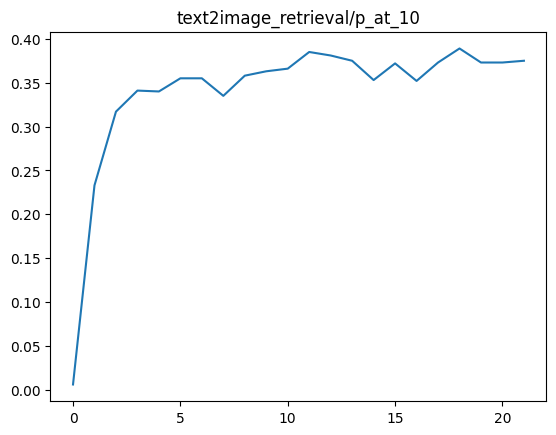

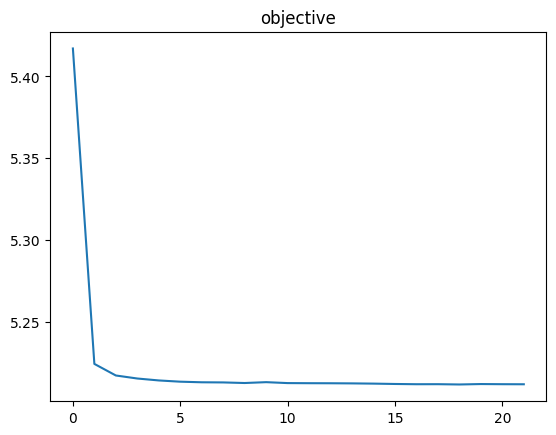

In [17]:
for k in info['metric_values']:
    if k == 'objective':
        plt.figure()
        plt.title('objective')
        plt.plot(info['metric_values'][k])
        continue
    for result in info['metric_values'][k]:
        plt.figure()
        plt.title(f'{k}/{result}')
        plt.plot(info['metric_values'][k][result])
plt.show()

The same can be done for the progression of weights during training:

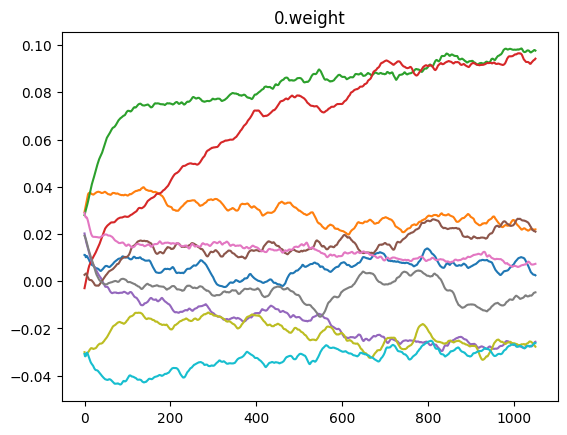

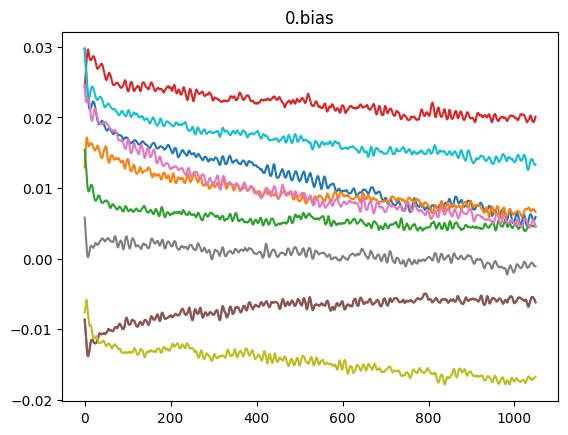

In [18]:
for parameter in info['weights']:
    plt.figure()
    plt.title(parameter)
    plt.plot(info['weights'][parameter])

We see that our model provides quick retrievals using its simpler architecture, and we succeeded in doing this with a very small resource footprint:

  0%|          | 0/81783 [00:00<?, ?it/s]

loading hashes: "simple_image_search"


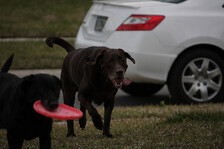

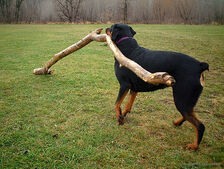

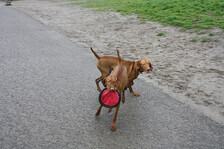

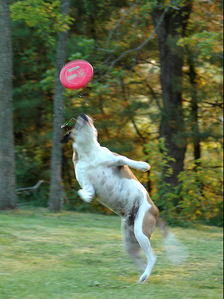

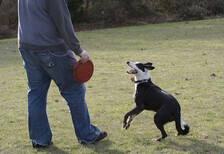

In [19]:
from IPython.display import display

docs.semantic_index = 'simple_image_search'
for r in docs.find(like={'captions': ['Dog catches frisbee']}, n=5):
    display(r['img'])

Let's see how well our model has done:

In [21]:
docs.validate_semantic_index('simple_image_search', ['text2image_retrieval'], ['p_at_10'])
docs['_objects'].find_one({'name': 'simple_image_search', 'varieties': 'semantic_index'}, {'final_metrics': 1})

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

loading hashes: "simple_image_search"


{'_id': ObjectId('63fe61339ef33c2039730554'),
 'final_metrics': {'text2image_retrieval': {'p_at_10': 0.386}}}